# COMP90051 Project 1

**Copyright statement:** This notebook is copyright University of Melbourne. 
It is licensed for the sole purpose of your assessment in COMP90051. 
You are not permitted to share or publish derived versions of this notebook, other than with COMP90051 staff for assessment.

***

The code block below imports the namespaces/functions/classes you may use in the project. 
Additional imports are not permitted.

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import ndarray
from typing import List, Optional, Tuple, Callable
import random
import copy
import tqdm
from abc import ABC, abstractmethod
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 108
RND_SEED = 90

The base `SVM` class below defines a common interface for a support vector machine. 
Your implementations below for each part of the project should inherit from this class. Feel free to add to this class if you need.

In [2]:
class SVM(ABC):
    """Base class for a support vector machine (SVM)"""
    
    def __init__(self) -> None:
        pass
        
    @abstractmethod
    def fit(self, X, y) -> None:        
        """Fit the model with the given training data.
        
        Parameters
        ----------        
        X : float numpy.ndarray, shape (n_samples, n_features)
            An array of training instances. 
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to training instances.
        -------
        """
    
    @abstractmethod
    def predict(self, test_X) -> int:
        """Predict label for given test samples

        Parameters
        ----------        
        test_X : float numpy.ndarray, shape (n_samples, n_features)
            An array of test instances. 

        -------
        Return 
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Predict labels array for test samples.
        """
        
    def evaluate(self, test_X, test_y) -> int:
        """Return the mean accuracy on the given test samples and labels.

        Parameters
        ----------        
        test_X : float numpy.ndarray, shape (n_samples, n_features)
            An array of test instances. 
        test_y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to training instances.
        -------
        Return : float, mean accuracy

        """
            
        pred_y = self.predict(test_X)
        acc = (pred_y == test_y).sum() / len(test_y)
        return acc
    
    def visualize(self, X, y) -> None:
        """Plot data and decision surface of fitted model. 
        This function is adapted from 
        https://stackoverflow.com/questions/51297423/plot-scikit-learn-sklearn-svm-decision-boundary-surface

        Parameters
        ----------        
        X : float numpy.ndarray, shape (n_samples, n_features)
            An array of instances. 
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to X.
        -------
        """
        y = np.array(y).squeeze()
        X = np.array(X)
        
        assert X.ndim == 2, "The shape of X must be (n_samples, n_features)"
        assert X.shape[0] == y.shape[0], "Inconsistent number of instances and labels"
        assert set(y) == set([1,-1]), "Labels must be 1 or -1"
        
        def make_meshgrid(x, y, h=.02):
            x_min, x_max = x.min() - 1, x.max() + 1
            y_min, y_max = y.min() - 1, y.max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            return xx, yy

        def plot_contours(ax, clf, xx, yy, **params):
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            out = ax.contourf(xx, yy, Z, **params)
            return out
        
        fig, ax = plt.subplots()
        title = ('Decision surface of SVM')
        # Set-up grid for plotting.
        X0, X1 = X[:, 0], X[:, 1]
        xx, yy = make_meshgrid(X0, X1)

        plot_contours(ax, self, xx, yy, cmap=plt.cm.Pastel1)
        ax.scatter(X[y==-1,0], X[y==-1,1], color='b', label="$y = -1$")
        ax.scatter(X[y==1,0], X[y==1,1], color='r', label="$y = 1$")

        ax.set_ylabel('$x_1$')
        ax.set_xlabel('$x_2$')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
        ax.legend()
        plt.show()

### Binary classification data
First, we will generate some toy binary classification data, re-using the code from workshop 4. This will be used for parts 1-3, and the start of part 4.

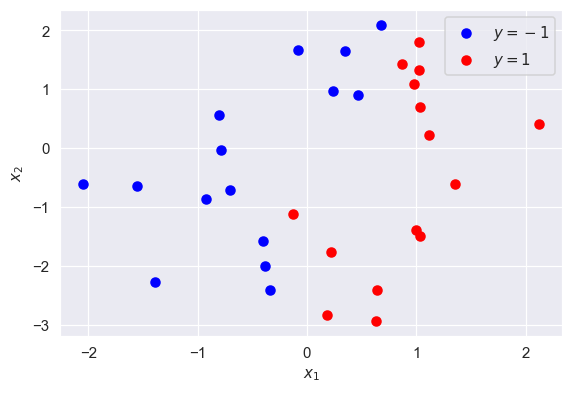

In [3]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = 30, n_features = 2, n_informative=2, n_redundant=0, random_state=RND_SEED)
y = np.where(y <=0, -1, 1)
X_b = np.column_stack((np.ones_like(y), X))

plt.scatter(X[y==-1,0], X[y==-1,1], color='b', label="$y = -1$")
plt.scatter(X[y==1,0], X[y==1,1], color='r', label="$y = 1$")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

## Part 1: Primal soft-margin SVM

In [40]:
class PrimalSVM(SVM):
    """Soft-margin SVM fit using primal objective, training 
    with stochastic gradient ascent.

    Parameters
    ----------
    eta : float
        Learning rate.
    lambda0: float
        Regularisation term, must be strictly positive
    """
    
    def __init__(self, eta, lambda0) -> None:
        self.w = None
        self.b = 0
        self.eta = eta
        self.lambda0 = lambda0
        
    def fit(self, X, y, iterations = 100) -> None:
        self.w = np.zeros(X.shape[1])
        for t in range(iterations):
            # loop over individual elements in X
            for i in range(X.shape[0]):
                if y[i]*(np.dot(self.w, X[i,:]) + self.b) < 1:
                    self.w -= self.eta * (-y[i]*X[i,:] + self.lambda0 * self.w / X.shape[0])
                    self.b -= self.eta * (-y[i])
                else:
                    self.w -= self.eta*self.lambda0*self.w/X.shape[0]

    def predict(self, test_X) -> int: 
        return np.where(np.dot(test_X, self.w) + self.b >= 0, 1, -1)

Accuracy is 0.9667


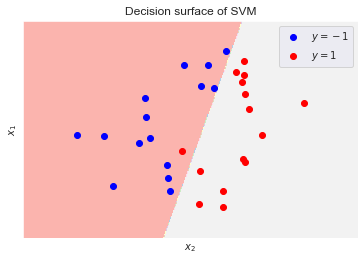

In [41]:
psvm = PrimalSVM(eta = 0.1, lambda0=0.1)
psvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(psvm.evaluate(X,y),4)}")
psvm.visualize(X,y)

### Tuning lambda value

lambda = 1e-10, accuracy = 0.9667
lambda = 1.2915496650148827e-10, accuracy = 0.9667
lambda = 1.6681005372000558e-10, accuracy = 0.9667
lambda = 2.1544346900318867e-10, accuracy = 0.9667
lambda = 2.782559402207126e-10, accuracy = 0.9667
lambda = 3.593813663804626e-10, accuracy = 0.9667
lambda = 4.6415888336127727e-10, accuracy = 0.9667
lambda = 5.994842503189421e-10, accuracy = 0.9667
lambda = 7.742636826811277e-10, accuracy = 0.9667
lambda = 1e-09, accuracy = 0.9667
lambda = 1.2915496650148826e-09, accuracy = 0.9667
lambda = 1.6681005372000556e-09, accuracy = 0.9667
lambda = 2.1544346900318866e-09, accuracy = 0.9667
lambda = 2.7825594022071257e-09, accuracy = 0.9667
lambda = 3.5938136638046257e-09, accuracy = 0.9667
lambda = 4.641588833612773e-09, accuracy = 0.9667
lambda = 5.994842503189421e-09, accuracy = 0.9667
lambda = 7.742636826811278e-09, accuracy = 0.9667
lambda = 1e-08, accuracy = 0.9667
lambda = 1.2915496650148827e-08, accuracy = 0.9667
lambda = 1.6681005372000592e-08, accur

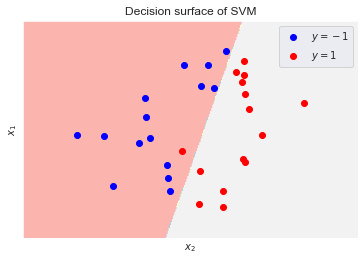

In [43]:
# Use this cell for experimentation 1.b
lambda_range = np.logspace(-10, 1, 100)
accuracies = []
for lambda1 in lambda_range:
    psvm = PrimalSVM(eta = 0.1, lambda0=lambda1)
    psvm.fit(X,y, iterations = 100)
    accuracy = round(psvm.evaluate(X,y),4)
    accuracies.append((lambda1, accuracy))
for a in accuracies:
    print(f"lambda = {a[0]}, accuracy = {a[1]}")
# print(accuracies)

# visulize lambda = 0.001
psvm = PrimalSVM(eta = 0.1, lambda0=0.001)
psvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(psvm.evaluate(X,y),4)}")
psvm.visualize(X,y)

## Part 2: Dual soft-margin SVM

In [44]:
class DualSVM(SVM):
    """Soft-margin SVM using dual formulation, training 
    with stochastic gradient ascent

    Parameters
    ----------
    eta : float
        Learning rate.
    C: float
        Regularization parameter.
    kernel: Kernel
        Kernel function
    """
    
    def __init__(self, eta, C, kernel = None):
        super().__init__()
        if kernel is None:
            def dot_product(u,v):
                return np.dot(u, v.T)
            self.kernel = dot_product
        else:
            self.kernel = kernel
            
        self.eta = eta
        self.C = C

    
    def fit(self, X, y, iterations = 100):
        
        super().fit(X=X,y=y)
        self.X = X
        self.y = y
        
        # lagrange multipliers (sometimes denoted lambda), you should initialize with 0s
        self.alphas = np.zeros(X.shape[0]) 
        
        for t in range(iterations):
            # loop over individual elements in X
            for i in range(X.shape[0]):
                s = 0
                for j in range(self.X.shape[0]):
                    s += self.alphas[j]*y[j]*self.kernel(X[i], X[j]) 
                self.alphas[i] += self.eta * (1 - y[i]*s)
                if self.alphas[i] < 0:
                    self.alphas[i] = 0
                elif self.alphas[i] > self.C:
                    self.alphas[i] = self.C
        
        
        self.bias = self.get_bias()
            
        return self.alphas
     
    def predict(self, test_X):
        result = np.zeros(test_X.shape[0])
        
        for j in range(test_X.shape[0]):
            s = 0
            for i in range(self.X.shape[0]):
                s += self.alphas[i]*self.y[i]*self.kernel(self.X[i], test_X[j]) 
            result[j] = (np.where(s + self.bias >= 0, 1, -1))
        return result
    
    def primal_weights(self):
        """Compute weights based on alphas, assuming linear kernel
        """
        w = np.zeros(self.X.shape[1])
        
        for i in range(self.X.shape[0]):
            w += self.alphas[i] * self.y[i] * self.X[i]
        return w
    
    def get_bias(self):
        """Compute bias based on learned alphas and training data set
        """

        s = 0
        for i in range(self.X.shape[0]):

            t = 0
            for j in range(self.X.shape[0]):
                t += self.alphas[j]*self.y[j]*self.kernel(self.X[i], self.X[j]) 
            s += self.y[i] - t
        return s/self.X.shape[0]
                

Accuracy is 0.9667


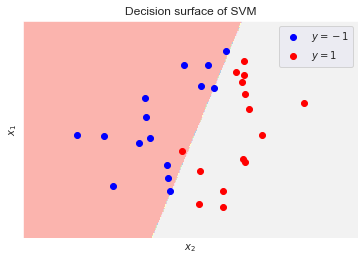

In [45]:
dsvm = DualSVM(eta = 0.1, C = 100)
dsvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(dsvm.evaluate(X,y),4)}")
dsvm.visualize(X,y)
# print(dsvm.bias)
# print(dsvm.primal_weights())

### Tuning C value

Accuracy is 0.5 (c = 0)
Accuracy is 0.9667 (c = 5)
Accuracy is 0.9333 (c = 10)
Accuracy is 0.9333 (c = 15)
Accuracy is 0.9667 (c = 20)
Accuracy is 0.9667 (c = 25)
Accuracy is 0.9667 (c = 30)
Accuracy is 0.9667 (c = 35)
Accuracy is 0.9667 (c = 40)
Accuracy is 0.9667 (c = 45)
Accuracy is 0.9667 (c = 50)
Accuracy is 0.9667


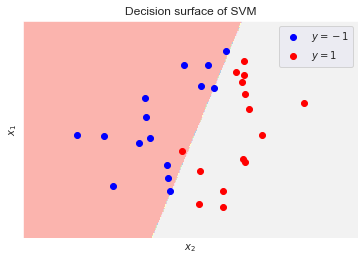

In [47]:
c = 10
for i in range(11):
    dsvm = DualSVM(eta = 0.1, C = 5*i)
    dsvm.fit(X,y, iterations = 100)
    print(f"Accuracy is {round(dsvm.evaluate(X,y),4)} (c = {i*5})")
dsvm = DualSVM(eta = 0.1, C = 50)
dsvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(dsvm.evaluate(X,y),4)}")
dsvm.visualize(X,y)

### Compare weights between primal and dual

In [48]:
from numpy.linalg import norm

# lambda = 0.03162 since it achieves max accuracy in question 1
# C = 1/lambda = 32
print("DualSVM:")
dsvm = DualSVM(eta = 0.1, C = 32)
dsvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(dsvm.evaluate(X,y),4)}")

dw = dsvm.primal_weights()
print(dw)

print("--------------")
print("PrimalSVM:")
psvm = PrimalSVM(eta = 0.1, lambda0 = 0.03162)
psvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(psvm.evaluate(X,y),4)}")

pw = psvm.w
print(pw)
print("--------------")
diff = norm(dw/norm(dw)-pw/norm(pw))
print(f"Difference: {diff}")

DualSVM:
Accuracy is 0.9667
[ 1.41067863 -0.33298488]
--------------
PrimalSVM:
Accuracy is 0.9667
[ 6.18866357 -1.40827248]
--------------
Difference: 0.008056148933183476


### Identify support vectors and points where alpha=C

In [11]:
# Use this cell here for experimentation 2.c
dsvm = DualSVM(eta = 0.1, C = 0.1)
dsvm.fit(X,y, iterations = 100)
# print(f"Accuracy is {round(dsvm.evaluate(X,y),4)}")
# dsvm.visualize(X,y)
v = []
for i in range(dsvm.X.shape[0]):
    if dsvm.alphas[i] == dsvm.C:
        v.append(i)
print(v)

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 29]


## Part 3: Kernel

In [12]:
from numpy.linalg import norm

    
class Kernel():
    """Kernel class

    Parameters
    ----------
    kernel_type : str {linear, poly, rbf}
        Type of kernel be indicated.
    poly_degree: int
        Polynomial degree for polynormial kernel. 
    poly_offset: float
        Polynomial offset for polynomial kernel. 
    rbf_sigma: float
        Kernel coefficient for rbf kernel. 
    """
    
    def __init__(self, kernel_type = None, **kwargs):
        if kernel_type == "linear":
            self.kernel = self.linear_kernel
        if kernel_type == "poly":
            self.degree = kwargs.get('poly_degree')
            self.sigma = kwargs.get('poly_offset')
            self.kernel = self.poly_kernel
        if kernel_type == "rbf":
            self.sigma = kwargs.get('rbf_sigma')
            self.kernel = self.rbf_kernel
            
    def __call__(self,u,v):
        """Evaluate the kernel on a pair of inputs, possibly batched.
        Matrix input is comprised of instances as row vectors.

        Parameters
        ----------
        u: vector or matrix
            first instance(s), shape (n,) or (m,n)
        v: vector or matrix
            second instance(s), shape (n,) or (z,n)
        
        -------
        Return : Kernel matrix, float or shape(z,) or shape (m,z)

        """
        return self.kernel(u, v)
        
    def linear_kernel(self, u, v):
        return np.dot(u,v.T)

    def poly_kernel(self, u, v):
        return np.power(np.dot(u, v.T) + self.sigma, self.degree)
        

    def rbf_kernel(self, u, v):
        return np.exp(-self.sigma*norm(u-v))
        

### Test your kernel in the DualSVM

Accuracy is 0.9667


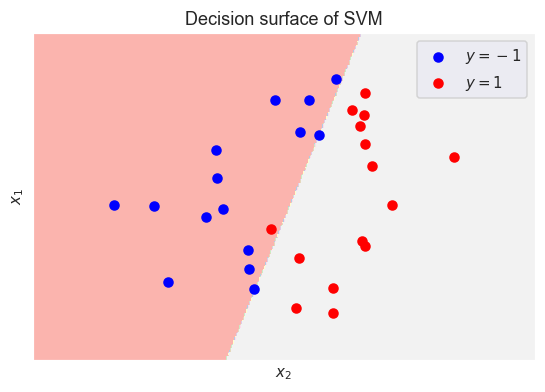

In [13]:
# Use this cell here for experimentation 3, e.g., 

dsvm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('linear'))
dsvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(dsvm.evaluate(X,y),4)}")
dsvm.visualize(X,y)

Accuracy is 0.9


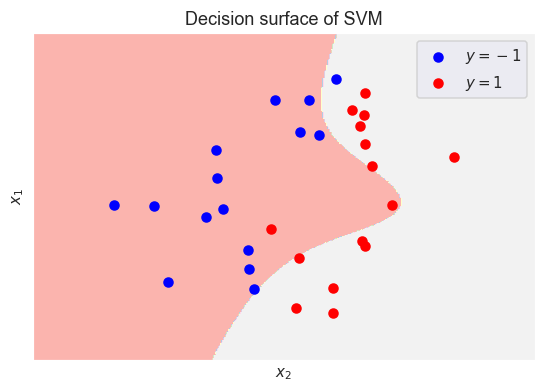

In [14]:
dsvm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('poly', poly_degree = 3, poly_offset = 1))
dsvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(dsvm.evaluate(X,y),4)}")
dsvm.visualize(X,y)

Accuracy is 0.7


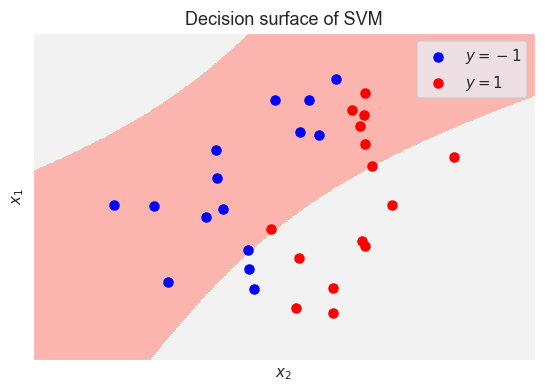

In [15]:
dsvm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('poly', poly_degree = 2, poly_offset = 1))
dsvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(dsvm.evaluate(X,y),4)}")
dsvm.visualize(X,y)

Accuracy is 1.0


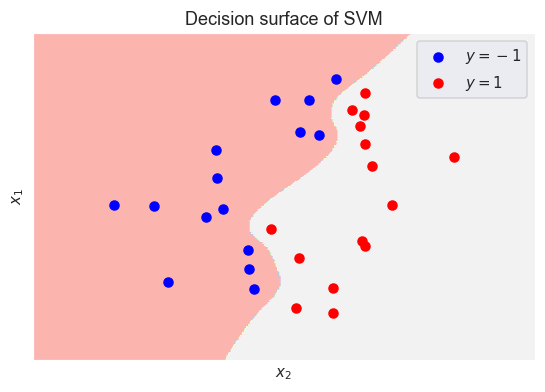

In [16]:
dsvm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('rbf',rbf_sigma = 1))
dsvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(dsvm.evaluate(X,y),4)}")
dsvm.visualize(X,y)

Accuracy is 1.0


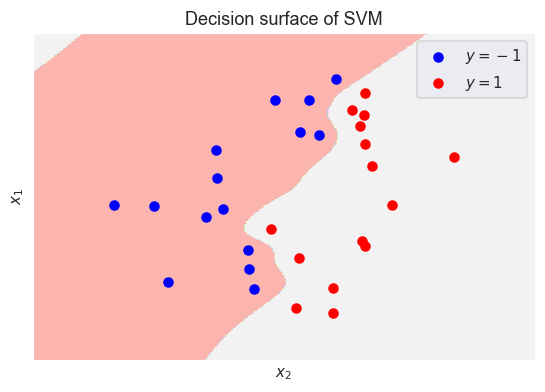

In [17]:
dsvm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('rbf',rbf_sigma = 5))
dsvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(dsvm.evaluate(X,y),4)}")
dsvm.visualize(X,y)

Accuracy is 1.0


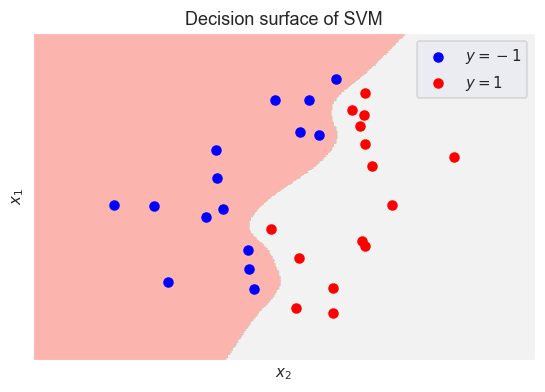

In [18]:
dsvm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('rbf',rbf_sigma = 0.5))
dsvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(dsvm.evaluate(X,y),4)}")
dsvm.visualize(X,y)

RBF Kernel is best suited to this problem. <br>
Since the given data set is not linear separable, using a linear kernel cannot separate two classes perfectly.<br>
For the poly kernel, it is not suitable for this data set, after I ran some experiments, it even performs worse than linear kernel. <br>
RBF kernel is the best for this problem since the decision boundary perfectly separates two classes. 

## Part 4: SMO

In [19]:
def random_pairs_heuristic(svm):
    for i2 in range(svm.n_samples):
        i1 = random.randint(0,svm.n_samples-1)
        yield (i1, i2)

def all_pairs_heuristic(svm):
    for i2 in range(svm.n_samples):
        for i1 in range(i2+1, svm.n_samples):
            yield (i1, i2)
    
class SMO(SVM):    
    def __init__(self, C, eps, tol, kernel, heuristic = all_pairs_heuristic):
        super().__init__()
        """Soft-margin SVM using dual formulation, training with sequential minimal optimization 
        """
        self.C = C
        self.eps = eps
        self.tol = tol
        self.kernel = kernel
        self.heuristic = heuristic
        
    def fit(self, X, y, iterations = 100):

        """Fit function for training SVM
        
        Parameters
        ----------
        iterations: int
            Stop training after this many iterations, even if not converged.
        """

        super().fit(X=X,y=y)
        self.X = X
        self.y = y
        self.b = 0
        self.alphas = np.zeros(X.shape[0])
        self.n_samples, self.n_features = X.shape
        self.K = self.kernel(self.X, self.X)
        self.update_errors()
        
        num_changed = 1
        complete_pass = False
        epoch = 1
        total_changed = total_examined = 0
        for epoch in tqdm.trange(iterations):
            num_changed = num_examined = 0
            if not complete_pass:
                to_visit = self.heuristic(self)
            else:
                # force a full pass over all pairs of points
                # if previous epoch had no updates, to confirm
                # that model has converged
                to_visit = all_pairs_heuristic(self)
            for i1, i2 in to_visit:
                if self.__take_step(i1, i2):
                    num_changed += 1
                num_examined += 1

            epoch += 1
            total_changed += num_changed
            total_examined += num_examined
            if complete_pass and num_changed == 0:
                break
            complete_pass = (num_changed == 0)            
            
        if complete_pass and num_changed == 0:
            print('converged, total changed', total_changed, 'examined', total_examined)
        else:
            print('not converged, total changed', total_changed, 'examined', total_examined)

        return
    
    def lower(self, i1, i2):
        ### your code here ###
        y1 = self.y[i1]
        y2 = self.y[i2]
        if y1 != y2:
            return max(0, self.alphas[i2]-self.alphas[i1])
        else:
            return max(0, self.alphas[i2]+self.alphas[i1]-self.C)
        ### end of your code ###

    def higher(self, i1, i2):
        ### your code here ###
        y1 = self.y[i1]
        y2 = self.y[i2]
        if y1 != y2:
            return min(self.C, self.C+self.alphas[i2]-self.alphas[i1])
        else:
            return min(self.C, self.alphas[i2]+self.alphas[i1])
        ### end of your code ###
    
    def update_errors(self):
        self.errors = np.dot(self.alphas * self.y, self.K) - self.b  - self.y    

    def __take_step(self, i1, i2):
        if (i1 == i2):
            return False
        
        # extract alphas for two instances and calculate errors
        alpha1 = self.alphas[i1]
        alpha2 = self.alphas[i2]
        y1 = self.y[i1]
        y2 = self.y[i2]
        E1 = self.errors[i1]
        E2 = self.errors[i2]
        s = y1 * y2
        
        L = self.lower(i1, i2)
        H = self.higher(i1, i2)
        
        if L == H:
            return False
        
        
        ### your code here        
        k11 = self.kernel(self.X[i1], self.X[i1]) # fill in 
        k12 = self.kernel(self.X[i1], self.X[i2]) # fill in
        k22 = self.kernel(self.X[i2], self.X[i2]) # fill in
        
        eta = k11+k22-2*k12 # fill in
        if eta <= 0: 
            return False # we will ignore this corner case
        
        new_a2 = alpha2 + y2*(E1-E2)/eta # fill in
        if new_a2 < L:
            new_a2 = L
        elif new_a2 > H:
            new_a2 = H
        ### end of your code
                    
        if abs(new_a2-alpha2) < self.eps * (new_a2 + alpha2 + self.eps):
            return False
        
        # update alphas, bias and errors
        new_a1 = alpha1 + s * (alpha2 - new_a2)
        self.b = self.update_bias(new_a1, new_a2,  i1, i2, k11, k12, k22)
        self.update_errors()
        self.alphas[i1] = new_a1
        self.alphas[i2] = new_a2
        
        return True

    def update_bias(self, new_a1, new_a2, i1, i2, k11, k12, k22):
        
        # extract alphas for two instances and calculate errors
        alpha1 = self.alphas[i1]
        alpha2 = self.alphas[i2]
        y1 = self.y[i1]
        y2 = self.y[i2]
        E1 = self.errors[i1]
        E2 = self.errors[i2]
        
        ### your code here ###
        b1 = E1 + y1*(new_a1-alpha1)*k11 + y2*(new_a2-alpha2)*k12 + self.b
        b2 = E2 + y1*(new_a1-alpha1)*k12 + y2*(new_a2-alpha2)*k22 + self.b
        
        return (b1+b2)/2
        ### end of your code ###
    
    def predict(self, test_X):
        ### your code here ###
        result = np.zeros(test_X.shape[0])
        for j in range(test_X.shape[0]):
            s = 0
            for i in range(self.X.shape[0]):
                s += self.alphas[i]*self.y[i]*self.kernel(self.X[i], test_X[j]) 
            result[j] = (np.where(s - self.b >= 0, 1, -1))
        return result
        ### end of your code ###   
    

  6%|██▌                                       | 6/100 [00:00<00:00, 350.98it/s]


converged, total changed 84 examined 3045
Accuracy is 0.9667


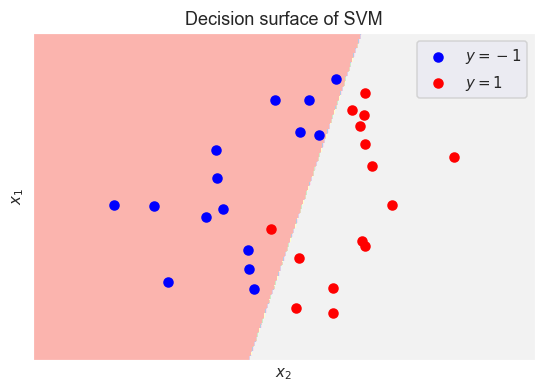

In [20]:
svm = SMO(C = 1,eps = 0.01,tol = 0.001,kernel = Kernel('linear'))
svm.fit(X,y,iterations = 100)
print(f"Accuracy is {round(svm.evaluate(X,y),4)}")
svm.visualize(X,y)

 21%|████████▌                                | 21/100 [00:00<00:00, 156.58it/s]


converged, total changed 346 examined 9570
Accuracy is 1.0


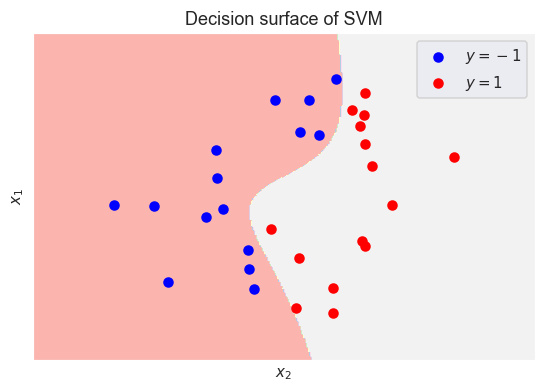

In [21]:
svm = SMO(C = 1,eps = 0.01,tol = 0.001,kernel = Kernel('poly', poly_degree = 3, poly_offset = 2))
svm.fit(X,y,iterations = 100)
print(f"Accuracy is {round(svm.evaluate(X,y),4)}")
svm.visualize(X,y)

 27%|███████████                              | 27/100 [00:00<00:00, 160.13it/s]


converged, total changed 1242 examined 12180
Accuracy is 1.0


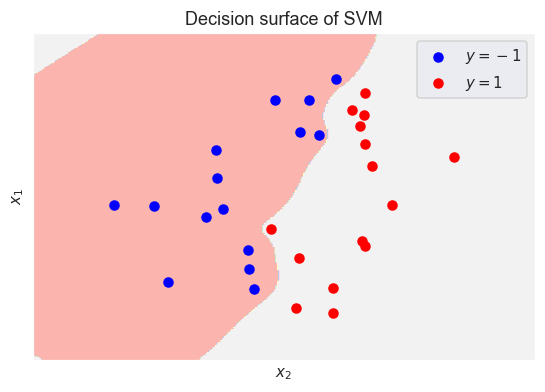

In [22]:
svm = SMO(C = 1,eps = 0.01,tol = 0.001,kernel = Kernel('rbf', rbf_sigma = 2))
svm.fit(X,y,iterations = 100)
print(f"Accuracy is {round(svm.evaluate(X,y),4)}")
svm.visualize(X,y)

### Fashion MNIST dataset and heuristic functions

The code below loads a part of the fashion-MNIST dataset, comprising pictures of clothing. The challenge is to classify the clothing by type. We have taken just two classes.

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/ziyangh/opt/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random', 'diff', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


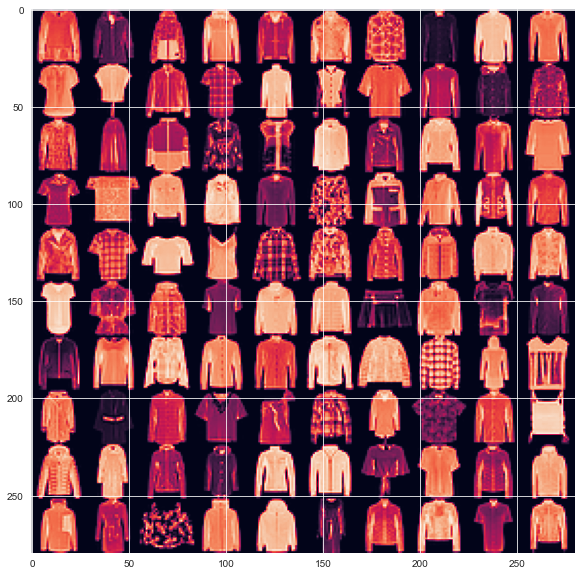

In [23]:
# extract a stack of 28x28 bitmaps
from sklearn.model_selection import train_test_split
%pylab inline

pics = np.loadtxt('train.csv', delimiter=' ')
Xf = pics[:, 0:784]
Xf = np.array([i/255 for i in Xf])

# extract labels for each bitmap
yf = pics[:, 784:785]
yf = np.array([int(i[0]) for i in yf])

# display a sample of the data
def gallery(array, ncols):
    nindex, height, width = array.shape
    nrows = nindex//ncols
    result = (array.reshape((nrows, ncols, height, width))
              .swapaxes(1,2)
              .reshape((height*nrows, width*ncols)))
    return result

ncols = 10
result = gallery(Xf.reshape((1200, 28, 28))[:ncols**2], ncols)
plt.figure(figsize=(10,10))
plt.imshow(result, interpolation=None)

# split data into a modest size training set, reserving the rest for testing
X_train, X_test, y_train, y_test = train_test_split(Xf, yf, test_size=600, random_state=RND_SEED)

- Primal SVM

In [24]:
psvm = PrimalSVM(eta = 0.1, lambda0=0.03162)
psvm.fit(X_train, y_train, iterations = 100)
print(f"Training Accuracy is {round(psvm.evaluate(X_train, y_train),4)}")
print(f"Evaluation Accuracy is {round(psvm.evaluate(X_test, y_test),4)}")

Training Accuracy is 0.735
Evaluation Accuracy is 0.7267


- Dual SVM

In [25]:
dsvm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('linear'))
dsvm.fit(X_train, y_train, iterations = 100)
print(f"Training Accuracy is {round(dsvm.evaluate(X_train, y_train),4)}")
print(f"Evaluation Accuracy is {round(dsvm.evaluate(X_test, y_test),4)}")

Training Accuracy is 0.865
Evaluation Accuracy is 0.8267


In [26]:
dsvm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('poly', poly_degree = 2, poly_offset = 1))
dsvm.fit(X_train, y_train, iterations = 100)
print(f"Training Accuracy is {round(dsvm.evaluate(X_train, y_train),4)}")
print(f"Evaluation Accuracy is {round(dsvm.evaluate(X_test, y_test),4)}")

Training Accuracy is 0.86
Evaluation Accuracy is 0.8283


In [27]:
dsvm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('rbf', rbf_sigma = 2))
dsvm.fit(X_train, y_train, iterations = 100)
print(f"Training Accuracy is {round(dsvm.evaluate(X_train, y_train),4)}")
print(f"Evaluation Accuracy is {round(dsvm.evaluate(X_test, y_test),4)}")

Training Accuracy is 1.0
Evaluation Accuracy is 0.825


- SMO

In [28]:
# Use this cell here for experimentation 4.b
svm = SMO(C = 1,eps = 0.01,tol = 0.001,kernel = Kernel('linear'))
svm.fit(X_train, y_train, iterations = 100)
print(f"Training Accuracy is {round(svm.evaluate(X_train, y_train),4)}")
print(f"Evaluation Accuracy is {round(svm.evaluate(X_test, y_test),4)}")

100%|█████████████████████████████████████████| 100/100 [02:24<00:00,  1.45s/it]


not converged, total changed 42878 examined 17970000
Training Accuracy is 0.9967
Evaluation Accuracy is 0.835


In [29]:
svm = SMO(C = 1,eps = 0.01,tol = 0.001,kernel = Kernel('poly', poly_degree = 2, poly_offset = 2))
svm.fit(X_train, y_train, iterations = 100)
print(f"Training Accuracy is {round(svm.evaluate(X_train, y_train),4)}")
print(f"Evaluation Accuracy is {round(svm.evaluate(X_test, y_test),4)}")

  9%|███▊                                       | 9/100 [00:18<03:10,  2.09s/it]


converged, total changed 1137 examined 1797000
Training Accuracy is 0.9617
Evaluation Accuracy is 0.83


In [30]:
svm = SMO(C = 1,eps = 0.01,tol = 0.001,kernel = Kernel('rbf', rbf_sigma = 0.5))
svm.fit(X_train, y_train, iterations = 100)
print(f"Training Accuracy is {round(svm.evaluate(X_train, y_train),4)}")
print(f"Evaluation Accuracy is {round(svm.evaluate(X_test, y_test),4)}")

 23%|█████████▋                                | 23/100 [00:53<02:58,  2.32s/it]


converged, total changed 39891 examined 4312800
Training Accuracy is 0.8533
Evaluation Accuracy is 0.7417


In [49]:
def my_heuristic(svm):
    """A heuristic function of selecting which instance pairs 
    to process (with __take_step) over a single SMO epoch. 

    Parameters
    ----------
    svm : SMO class
    ----------
    Return
    list of (int, int) tuples, the indices for pairs of training instances
    """
    ### your code here ###
#     temp = []
#     for i1 in range(svm.n_samples):
#         # check if violates KKT condition
#         if svm.alphas[i1] != svm.C and svm.alphas[i1] != 0:
#             for i2 in range(svm.n_samples):
#                 # get error value
#                 delta = abs(svm.errors[i1] - svm.errors[i2])
#                 temp.append([delta, (i1, i2)])
#     # optimize those with large error first
#     temp.sort(key=lambda x:x[0], reverse=True)
#     for e in temp:
#         yield e[1]
    ### end of your code ###
    temp = []
    for i in range(svm.n_samples):
        if (svm.y[i]*svm.errors[i] > svm.tol and svm.alphas[i] > 0) or (svm.y[i]*svm.errors[i] < -svm.tol and svm.alphas[i] < svm.C):
            temp.append(i)
    result = []
    for i1 in temp:
        for i2 in range(svm.n_samples):
            delta = abs(svm.errors[i1] - svm.errors[i2])
            result.append([delta, (i1, i2)])
    result.sort(key=lambda x:x[0], reverse=True)
    for e in result:
        yield e[1]
            

- My heuristic
<br>early convergence compare to the two default heuristic
<br>faster and takes less steps

In [50]:
svm = SMO(C = 1,eps = 0.01,tol = 0.001,heuristic=my_heuristic,kernel = Kernel('linear'))
svm.fit(X_train, y_train, iterations = 200)
print(f"Accuracy is {round(svm.evaluate(X_test, y_test),4)}")

 78%|███████████████████████████████▉         | 156/200 [03:09<00:53,  1.22s/it]


converged, total changed 53060 examined 17270700
Accuracy is 0.8367


- random pairs and all pairs heuristic

In [33]:

svm = SMO(C = 1,eps = 0.01,tol = 0.001,heuristic=random_pairs_heuristic,kernel = Kernel('linear'))
svm.fit(X_train, y_train, iterations = 200)
print(f"Accuracy is {round(svm.evaluate(X_test, y_test),4)}")

100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 55.02it/s]


not converged, total changed 12310 examined 120000
Accuracy is 0.8383


In [34]:
svm = SMO(C = 1,eps = 0.01,tol = 0.001,heuristic=all_pairs_heuristic,kernel = Kernel('linear'))
svm.fit(X_train, y_train, iterations = 200)
print(f"Accuracy is {round(svm.evaluate(X_test, y_test),4)}")

 94%|██████████████████████████████████████▎  | 187/200 [04:16<00:17,  1.37s/it]


converged, total changed 44260 examined 33783600
Accuracy is 0.835
